# Hacker Earth Machine Learning Challenge 

## Problem Statement
The Bank Indessa has not done well in last 3 quarters. Their NPAs (Non Performing Assets) have reached all time high. It is starting to lose confidence of its investors. As a result, it’s stock has fallen by 20% in the previous quarter alone.
After careful analysis, it was found that the majority of NPA was contributed by loan defaulters. With the messy data collected over all the years, this bank has decided to use machine learning to figure out a way to find these defaulters and devise a plan to reduce them.
This bank uses a pool of investors to sanction their loans. For example: If any customer has applied for a loan of $20000, along with bank, the investors perform a due diligence on the requested loan application. Keep this in mind while understanding data.
In this challenge, you will help this bank by predicting the probability that a member will default.


### Solution Approach


# Importing needful libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import lightgbm as lgb
from sklearn.impute import SimpleImputer as Imputer
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import re
import timeit
import random
random.seed(3)

In [2]:
dataset = pd.read_csv("datasets/dataset.csv")

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
#dataset = dataset.sample(frac = 0.1, random_state=10)

In [5]:
#pd.DataFrame(dataset).to_csv('datasets/dataset.csv', index=False)

In [4]:
dataset.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,25386106,35000,35000,35000.0,60 months,,23.43,F,F1,Teacher,10+ years,MORTGAGE,135000.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,153xx,PA,27.14,0.0,2.0,NaN,NaN,49.0,0.0,31702.0,80.5,75.0,f,10702.29,0.00,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,74th week,0.0,0.0,346077.0,39400.0,0
1,61556649,19000,19000,18900.0,36 months,BAT1780517,9.99,B,B3,Chaplain,10+ years,RENT,79000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,130xx,NY,29.28,0.0,2.0,NaN,NaN,22.0,0.0,20238.0,61.1,35.0,f,774.22,30.65,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,22th week,0.0,0.0,110297.0,33100.0,0
2,12619165,6600,6600,6600.0,36 months,,14.98,C,C3,NaN,10+ years,OWN,80000.0,Source Verified,n,NaN,credit_card,Credit card refinancing,277xx,NC,13.11,2.0,0.0,2.0,NaN,18.0,0.0,4323.0,21.0,42.0,f,671.56,0.00,0.0,0.0,0.0,2.0,INDIVIDUAL,NaN,39th week,1.0,0.0,27591.0,20600.0,1
3,40473262,8000,8000,8000.0,36 months,BAT4722912,6.99,A,A3,Teacher,2 years,OWN,60000.0,Verified,n,NaN,major_purchase,Major purchase,137xx,NY,13.72,0.0,0.0,NaN,NaN,26.0,0.0,27804.0,32.3,33.0,f,506.57,0.00,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,57th week,0.0,0.0,117035.0,86200.0,0
4,42563178,10000,10000,10000.0,36 months,BAT4694572,9.49,B,B2,Server,4 years,RENT,36000.0,Source Verified,n,NaN,credit_card,Credit card refinancing,900xx,CA,17.93,2.0,0.0,12.0,NaN,9.0,0.0,9244.0,24.6,15.0,w,779.70,0.00,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,52th week,0.0,381.0,33736.0,37600.0,0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26621 entries, 0 to 26620
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   member_id                    26621 non-null  int64  
 1   loan_amnt                    26621 non-null  int64  
 2   funded_amnt                  26621 non-null  int64  
 3   funded_amnt_inv              26621 non-null  float64
 4   term                         26621 non-null  object 
 5   batch_enrolled               22394 non-null  object 
 6   int_rate                     26621 non-null  float64
 7   grade                        26621 non-null  object 
 8   sub_grade                    26621 non-null  object 
 9   emp_title                    25105 non-null  object 
 10  emp_length                   25314 non-null  object 
 11  home_ownership               26621 non-null  object 
 12  annual_inc                   26621 non-null  float64
 13  verification_sta

In [6]:
dataset.isnull().sum()

member_id                          0
loan_amnt                          0
funded_amnt                        0
funded_amnt_inv                    0
term                               0
batch_enrolled                  4227
int_rate                           0
grade                              0
sub_grade                          0
emp_title                       1516
emp_length                      1307
home_ownership                     0
annual_inc                         0
verification_status                0
pymnt_plan                         0
desc                           22783
purpose                            0
title                              3
zip_code                           0
addr_state                         0
dti                                0
delinq_2yrs                        0
inq_last_6mths                     0
mths_since_last_delinq         13503
mths_since_last_record         22586
open_acc                           0
pub_rec                            0
r

In [7]:
dataset.columns

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'batch_enrolled', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'application_type', 'verification_status_joint', 'last_week_pay',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'loan_status'],
      dtype='object')

In [8]:
y = dataset.loan_status.values
y.shape

(26621,)

## VISUALISATION

<AxesSubplot:xlabel='loan_status', ylabel='count'>

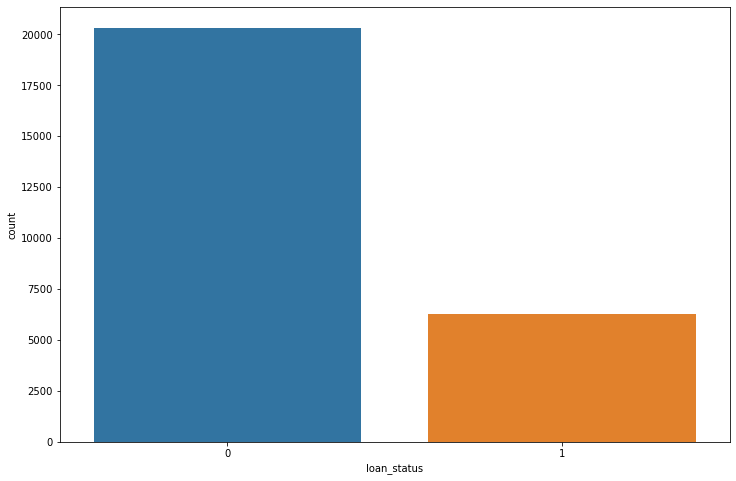

In [9]:
plt.figure(figsize = [12,8])
sns.countplot(x = 'loan_status', data = dataset)

<AxesSubplot:xlabel='purpose', ylabel='count'>

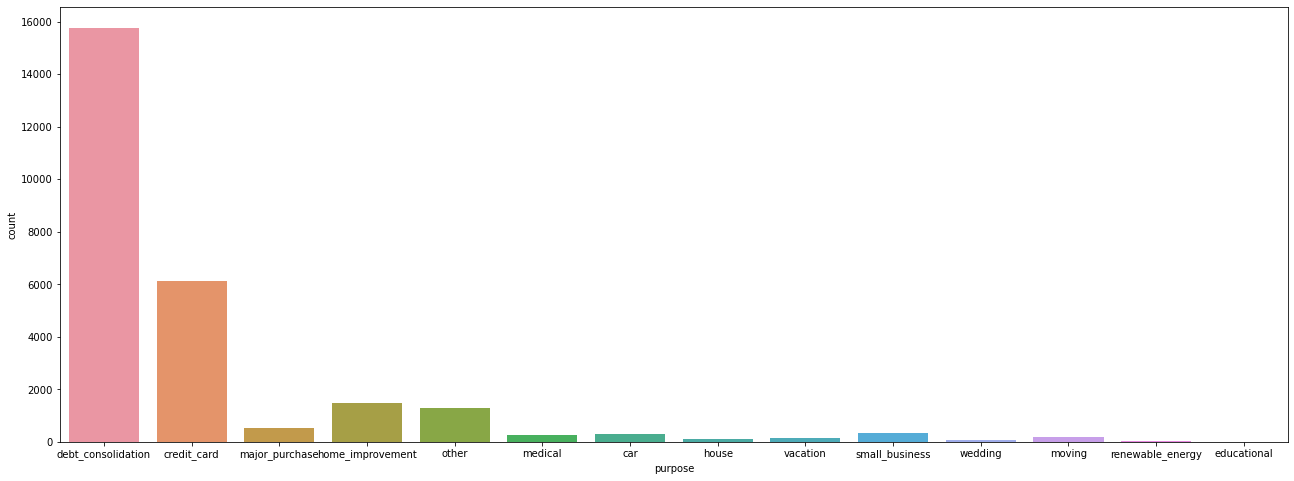

In [10]:
plt.figure(figsize=(22,8))
sns.countplot(x = 'purpose', data = dataset)

In [11]:
#dataset['home_ownership'].values_count()

<AxesSubplot:xlabel='home_ownership', ylabel='count'>

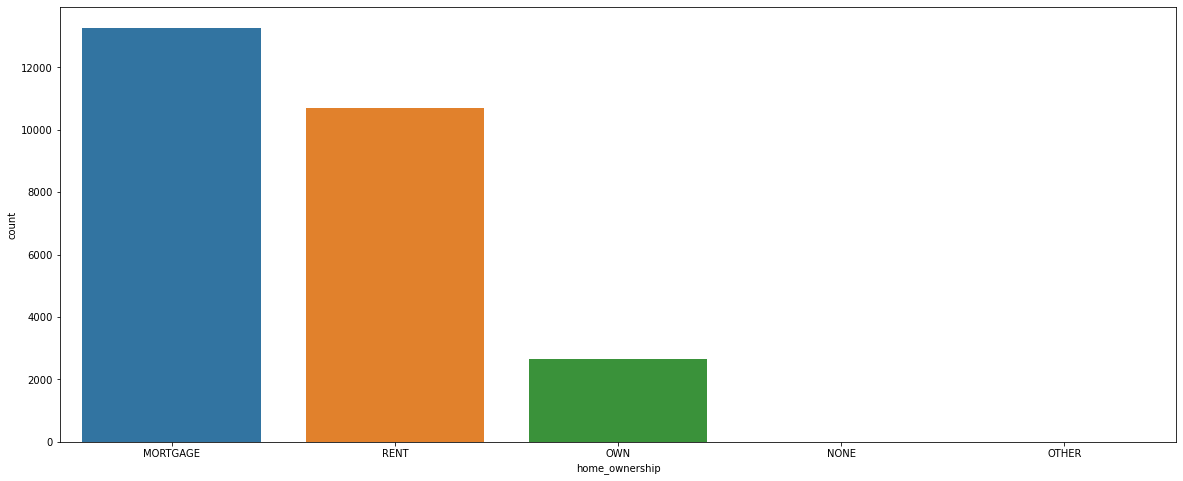

In [12]:
plt.figure(figsize=(20,8))
sns.countplot(x = 'home_ownership', data = dataset)

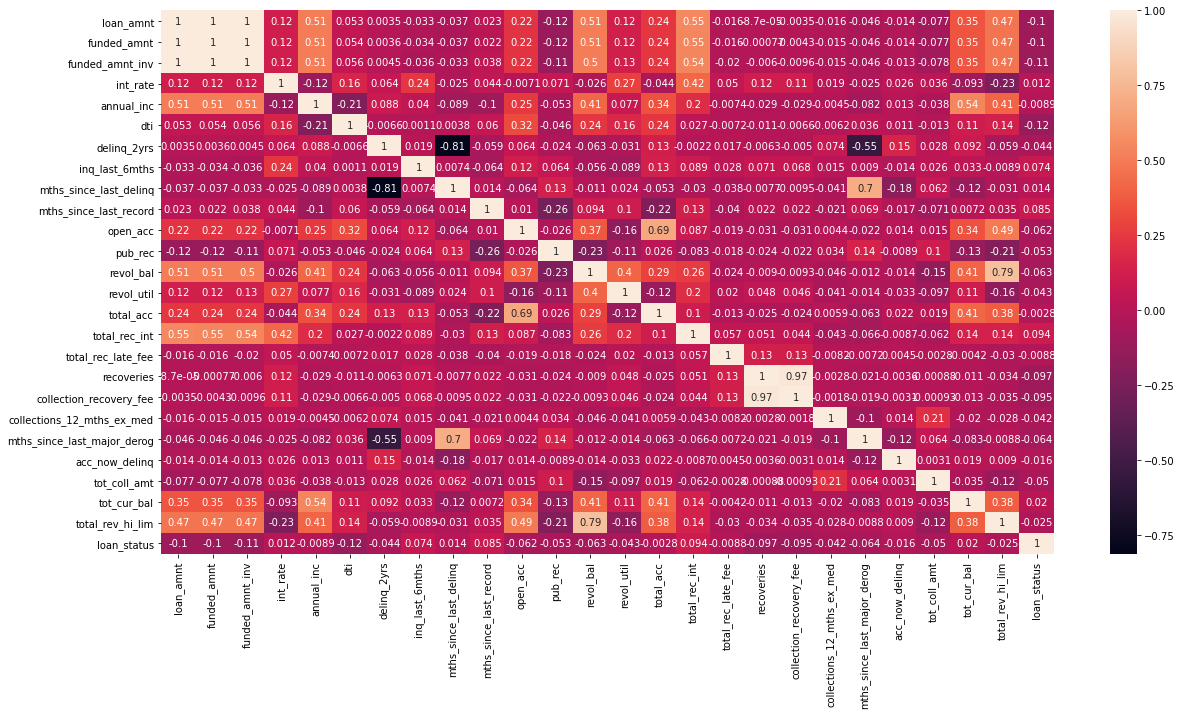

In [13]:
plt.figure(figsize=(20,10))
#cor = dataset.
cor = dataset.drop('member_id', axis=1).corr(method = 'spearman')
fig = sns.heatmap(cor, annot=True)
plt.show(fig)

In [14]:
#correlation, pval = spearmanr(dataset.drop("member_id",axis=1))
#print(f'correlation={correlation:.6f},p-value={pval:.6f}')
#from scipy.stats import rankdata
#sns.jointplot(x=dataset['emp_length'], y=dataset['loan_amnt'])

In [15]:
print(dataset.drop("member_id", axis=1).corr(method='spearman'))

                             loan_amnt  funded_amnt  funded_amnt_inv  \
loan_amnt                     1.000000     0.999438         0.996628   
funded_amnt                   0.999438     1.000000         0.997366   
funded_amnt_inv               0.996628     0.997366         1.000000   
int_rate                      0.119663     0.119912         0.119889   
annual_inc                    0.510594     0.510110         0.508614   
dti                           0.053009     0.053838         0.056468   
delinq_2yrs                   0.003515     0.003614         0.004519   
inq_last_6mths               -0.033394    -0.033565        -0.036465   
mths_since_last_delinq       -0.036907    -0.036648        -0.033242   
mths_since_last_record        0.022529     0.022305         0.038021   
open_acc                      0.221139     0.221522         0.222293   
pub_rec                      -0.116194    -0.115775        -0.113660   
revol_bal                     0.505228     0.505030         0.50

## DATA CLEANING 

## Droping some unwanted dependent variables

In [16]:
### columns undropped from original data ['grade','addr_state', 'pymnt_plan','verification_status','delinq_2yrs',]

In [17]:
drop_col = ['member_id','funded_amnt', 'funded_amnt_inv', 'batch_enrolled','sub_grade', 'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog','emp_title', 'desc','title','zip_code','verification_status_joint','last_week_pay','loan_status','recoveries']

In [100]:
dataset_1 = dataset.drop(['member_id','funded_amnt', 'funded_amnt_inv', 'batch_enrolled','mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog','sub_grade', 'emp_title', 'desc','title','zip_code','verification_status_joint','last_week_pay','loan_status','recoveries'], axis=1)

In [101]:
dataset_1.shape

(26621, 29)

In [102]:
dataset_1.emp_length.unique()

array(['10+ years', '2 years', '4 years', '5 years', '8 years', '6 years',
       '3 years', '7 years', nan, '< 1 year', '1 year', '9 years'],
      dtype=object)

In [103]:
columns  = dataset_1.columns
columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'total_rec_int', 'total_rec_late_fee',
       'collection_recovery_fee', 'collections_12_mths_ex_med',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim'],
      dtype='object')

In [104]:
dataset_1.application_type.unique()

array(['INDIVIDUAL', 'JOINT'], dtype=object)

### Converting objects variables to integers

In [23]:
dataset_1['emp_length'] = dataset_1['emp_length'].replace({np.nan:0, '< 1 year':1, '1 year':2, '2 years':3, '3 years':4, '4 years':5, '5 years':6, '6 years':7, '7 years':8, '8 years':9, '9 years':10, '10+ years':11})

dataset_1['term'] = dataset_1['term'].replace({'36 months':36, '60 months':60})

dataset_1['home_ownership']=dataset_1['home_ownership'].replace({'OWN':6, 'MORTGAGE':5, 'RENT':4, 'OTHER':3, 'NONE':2, 'ANY':1})

dataset_1['purpose'] = dataset_1['purpose'].replace({'small_business':1,'debt_consolidation':2, 'home_improvement':3, 'credit_card':4,'major_purchase':5,  
                                                     'vacation':6, 'car':7, 'moving':8,'medical':9, 'wedding':10, 'renewable_energy':11, 'house':12, 'educational':13,'other':14,})
dataset_1['application_type'] = dataset_1['application_type'].replace({'INDIVIDUAL':1, 'JOINT':2})

dataset_1['verification_status'] = dataset_1['verification_status'].replace({'Source Verified':1, 'Not Verified':0, 'Verified':1})

dataset_1['grade'] = dataset_1['grade'].replace({'E':2, 'B':5, 'A':6, 'D':3, 'C':4, 'F':1, 'G':0})

dataset_1['pymnt_plan'] = dataset_1['pymnt_plan'].replace({'n':0, 'y':1})

dataset_1['initial_list_status'] = dataset_1['initial_list_status'].replace({'f':1, 'w':0})

dataset_1['addr_state'] = dataset_1['addr_state'].replace({'ND':0, 'NE':0,'IA':0,'NV':0,'FL':0,'HI':0,'AL':0,'NY':0,'NM':1,'VA':1,'OK':2,'TN':2,'MO':2,'LA':2,'MD':2,'NC':2,'UT':3,
                 'KY':3,'AZ':3,'NJ':3,'AR':4,'MI':4,'PA':4,'OH':4,'MN':4,'CA':4,'RI':5,'MA':5,'DE':5,'SD':5,'IN':5,'GA':6,'WA':6,'OR':6,
                 'WI':7,'MT':7,'IL':8,'CT':8,'KS':9,'SC':9,'CO':9,'VT':9,'AK':9,'MS':9,'TX':9,'WV':10,'NH':10,'WY':10,'DC':10,'ME':10,'ID':10})

    

In [24]:
dataset_1.addr_state.unique()

array([ 4,  0,  2,  9,  3,  6,  8, 10,  1,  5,  7], dtype=int64)

## New features

In [25]:
dataset_1['term'] = dataset_1['term'].apply(lambda x: float(x))

In [26]:
value = -9999
def helping_features(value):
    i = ((dataset_1['int_rate'])/100)/12
    d = 1 - (1/(1+i)**dataset_1['term'])
    dataset_1['Monthly_supposed_payment'] = (dataset_1['loan_amnt']*i)/d
    dataset_1['Total_refund'] = dataset_1['Monthly_supposed_payment']*dataset_1['term']
    #dataset['Interest_amnt'] = dataset['Total_refund'] - dataset['loan_amnt']
    dataset_1['Monthly_income'] = dataset_1['annual_inc'].apply(lambda x : x/12 if x >=0 else -9999)

In [27]:
helping_features(-9999)
dataset_1.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,Monthly_supposed_payment,Total_refund,Monthly_income
0,35000,60.0,23.43,1,11,5,135000.0,1,0,2,4,27.14,0.0,2.0,49.0,0.0,31702.0,80.5,75.0,1,10702.29,0.00,0.0,0.0,0.0,1,0.0,0.0,346077.0,39400.0,995.332472,59719.948316,11250.000000
1,19000,36.0,9.99,5,11,4,79000.0,0,0,2,0,29.28,0.0,2.0,22.0,0.0,20238.0,61.1,35.0,1,774.22,30.65,0.0,0.0,0.0,1,0.0,0.0,110297.0,33100.0,612.987357,22067.544839,6583.333333
2,6600,36.0,14.98,4,11,6,80000.0,1,0,4,2,13.11,2.0,0.0,18.0,0.0,4323.0,21.0,42.0,1,671.56,0.00,0.0,0.0,0.0,1,1.0,0.0,27591.0,20600.0,228.726532,8234.155168,6666.666667
3,8000,36.0,6.99,6,3,6,60000.0,1,0,5,0,13.72,0.0,0.0,26.0,0.0,27804.0,32.3,33.0,1,506.57,0.00,0.0,0.0,0.0,1,0.0,0.0,117035.0,86200.0,246.980199,8891.287175,5000.000000
4,10000,36.0,9.49,5,5,4,36000.0,1,0,4,4,17.93,2.0,0.0,9.0,0.0,9244.0,24.6,15.0,0,779.70,0.00,0.0,0.0,0.0,1,0.0,381.0,33736.0,37600.0,320.282754,11530.179142,3000.000000


In [28]:
dataset_1.collections_12_mths_ex_med.unique()

array([ 0.,  1.,  2., nan,  4.,  3.,  5.])

## Filling missing values

In [29]:
dataset_1.isnull().sum()

loan_amnt                        0
term                             0
int_rate                         0
grade                            0
emp_length                       0
home_ownership                   0
annual_inc                       0
verification_status              0
pymnt_plan                       0
purpose                          0
addr_state                       0
dti                              0
delinq_2yrs                      0
inq_last_6mths                   0
open_acc                         0
pub_rec                          0
revol_bal                        0
revol_util                      15
total_acc                        0
initial_list_status              0
total_rec_int                    0
total_rec_late_fee               0
recoveries                       0
collection_recovery_fee          0
collections_12_mths_ex_med       4
application_type                 0
acc_now_delinq                   0
tot_coll_amt                  2138
tot_cur_bal         

In [30]:
def fill_nulls(value):
    cols_fill = ['collections_12_mths_ex_med','revol_util', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
    
    if value == -9999:
        for col in cols_fill:
            dataset_1.loc[dataset_1[col].isnull(), col] = -9999
    else : 
        for col in cols_fill:
            dataset_1.loc[dataset_1[col].isnull(), col] = dataset_1[col].mean()

In [31]:
fill_nulls(-9999)

In [32]:
dataset_1.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'Monthly_supposed_payment', 'Total_refund',
       'Monthly_income'],
      dtype='object')

In [33]:
dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26621 entries, 0 to 26620
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   26621 non-null  int64  
 1   term                        26621 non-null  float64
 2   int_rate                    26621 non-null  float64
 3   grade                       26621 non-null  int64  
 4   emp_length                  26621 non-null  int64  
 5   home_ownership              26621 non-null  int64  
 6   annual_inc                  26621 non-null  float64
 7   verification_status         26621 non-null  int64  
 8   pymnt_plan                  26621 non-null  int64  
 9   purpose                     26621 non-null  int64  
 10  addr_state                  26621 non-null  int64  
 11  dti                         26621 non-null  float64
 12  delinq_2yrs                 26621 non-null  float64
 13  inq_last_6mths              266

## SCALING THE DATASET 

In [34]:
columns = dataset_1.columns
columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'Monthly_supposed_payment', 'Total_refund',
       'Monthly_income'],
      dtype='object')

In [35]:
# Use 3 features
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_classif
df = SelectKBest(f_classif, k=3)
df1 = StandardScaler()
data_scale = df1.fit_transform(dataset_1) 
data = pd.DataFrame(data_scale, columns=columns)
data.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,Monthly_supposed_payment,Total_refund,Monthly_income
0,2.400992,1.521983,2.339654,-2.456020,1.123245,0.471572,0.836856,0.651534,0.0,-0.498236,-0.036645,1.092580,-0.360911,1.322423,7.144052,-0.314012,0.651221,0.129825,4.222159,0.972322,4.186758,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.070320,0.181932,1.390015,0.314391,2.295524,3.346880,0.836856
1,0.503562,-0.657038,-0.738189,0.602702,1.123245,-1.088284,0.053102,-1.534839,0.0,-0.498236,-1.369800,1.350092,-0.360911,1.322423,2.002063,-0.314012,0.145303,0.048922,0.830719,0.972322,-0.462838,7.309022,-0.117306,-0.079717,0.012138,-0.025278,-0.070320,0.181932,-0.120756,0.129189,0.725300,0.231720,0.053102
2,-0.966947,-0.657038,0.404552,-0.161979,1.123245,2.031429,0.067097,0.651534,0.0,0.208719,-0.703223,-0.595689,1.930758,-0.694837,1.240286,-0.314012,-0.557042,-0.118304,1.424221,0.972322,-0.510916,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,11.703155,0.181932,-0.650699,-0.238276,-0.852792,-0.912781,0.067097
3,-0.800922,-0.657038,-1.425208,1.367382,-0.935849,2.031429,-0.212815,0.651534,0.0,0.562197,-1.369800,-0.522286,-0.360911,-0.694837,2.763839,-0.314012,0.479198,-0.071180,0.661147,0.972322,-0.588186,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.070320,0.181932,-0.077582,1.690181,-0.777827,-0.858413,-0.212815
4,-0.563743,-0.657038,-0.852693,0.602702,-0.421075,-1.088284,-0.548710,0.651534,0.0,0.208719,-0.036645,-0.015685,1.930758,-0.694837,-0.473710,-0.314012,-0.339873,-0.103291,-0.865001,-1.028466,-0.460271,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.070320,0.297161,-0.611325,0.261477,-0.476786,-0.640086,-0.548710


### Spliting the test and trian data

In [36]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data,y, test_size=0.2, random_state=0)

In [37]:
X_train.shape

(21296, 33)

In [38]:
X_test.shape

(5325, 33)

In [39]:
y_train.shape

(21296,)

In [40]:
y_test.shape

(5325,)

# Training the Data - Model

In [41]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=1000)
classifier = classifier.fit(X_train, y_train)

In [42]:
y_pred = classifier.predict(X_test)

In [43]:
y_pred_prob = classifier.predict_proba(X_test)[:,1]
y_pred_prob

array([0.90390683, 0.05909546, 0.40042469, ..., 0.13531889, 0.07751969,
       0.13296182])

In [44]:
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.8208450704225352

In [45]:
classifier.coef_

array([[-1.36450136e+00, -3.69226192e-01,  2.11349183e+00,
         1.96965147e+00,  2.16719199e-02, -6.14806429e-03,
        -4.55984400e-02, -7.20872948e-02,  0.00000000e+00,
        -2.96435725e-02,  2.66267467e-02, -2.51844089e-01,
        -1.24189293e-01,  6.64031427e-02, -2.37529542e-01,
        -1.26514830e-01, -1.81207846e-01,  4.19655963e-03,
         3.09408858e-01,  3.14133845e-01, -1.98743804e-01,
        -8.02144151e-02, -6.84579470e+00, -1.57099433e+00,
        -1.65381263e-02, -1.61312142e-01, -3.44095695e-02,
        -1.14831721e+00,  1.79560905e-01,  1.50355116e-01,
         4.34500475e-01,  1.02133744e+00, -4.55984400e-02]])

In [46]:
### Manipulating the parameters - second model

In [47]:
model = LogisticRegression(max_iter=1000)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)


In [48]:
y_pred_1 = grid_result.predict(X_test)

In [49]:
accuracy_2 = metrics.accuracy_score(y_test, y_pred_1)
accuracy_2

0.8232863849765258

In [50]:
classifier.coef_

array([[-1.36450136e+00, -3.69226192e-01,  2.11349183e+00,
         1.96965147e+00,  2.16719199e-02, -6.14806429e-03,
        -4.55984400e-02, -7.20872948e-02,  0.00000000e+00,
        -2.96435725e-02,  2.66267467e-02, -2.51844089e-01,
        -1.24189293e-01,  6.64031427e-02, -2.37529542e-01,
        -1.26514830e-01, -1.81207846e-01,  4.19655963e-03,
         3.09408858e-01,  3.14133845e-01, -1.98743804e-01,
        -8.02144151e-02, -6.84579470e+00, -1.57099433e+00,
        -1.65381263e-02, -1.61312142e-01, -3.44095695e-02,
        -1.14831721e+00,  1.79560905e-01,  1.50355116e-01,
         4.34500475e-01,  1.02133744e+00, -4.55984400e-02]])

In [51]:
metrics.confusion_matrix(y_test, y_pred_1)

array([[3935,  127],
       [ 814,  449]], dtype=int64)

### XGBOOST MODEL

In [52]:
# xgboost for regression
start = timeit.default_timer()
from xgboost import XGBClassifier
model_xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='mlogloss')
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
y_pred_prob = model_xgb.predict_proba(X_test.values)[:,1]
stop = timeit.default_timer()
print(stop - start)

3.956163100000026


In [53]:
y_pred_prob = model_xgb.predict_proba(X_test.values)[:,1]
y_pred_prob

array([0.96377546, 0.00556015, 0.35822168, ..., 0.30831152, 0.07369682,
       0.14462224], dtype=float32)

In [54]:
accuracy_xgb = metrics.accuracy_score(y_test, y_pred_xgb)
accuracy_xgb
'{:.2f}'.format(accuracy_xgb)

'0.85'

# Save Our Model
* Serialization
* Pickle
* Joblib
* numpy/json/ray

In [55]:
# Using Joblib
import joblib

model_file = open("models/classifier_model.pkl","wb")
joblib.dump(classifier,model_file)
model_file.close()

model_file = open("models/classifier_model_2.pkl","wb")
joblib.dump(grid_result,model_file)
model_file.close()

Prediction = pd.DataFrame({
    'member_id' : member_id,
    'loan_status' : stack_result_prob
})
Prediction = Prediction[['member_id','loan_status']]

Prediction.to_csv('datasets/Prdeiction.csv', index = False)

# Creating the summary table

In [56]:
feature_name = ['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'Monthly_supposed_payment', 'Total_refund',
       'Monthly_income']

In [57]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(classifier.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', classifier.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-2.324182
1,loan_amnt,-1.364501
2,term,-0.369226
3,int_rate,2.113492
4,grade,1.969651
5,emp_length,0.021672
6,home_ownership,-0.006148
7,annual_inc,-0.045598
8,verification_status,-0.072087
9,pymnt_plan,0.000000


In [58]:
inputs_train = X_train
X_train.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,Monthly_supposed_payment,Total_refund,Monthly_income
19765,1.570866,1.521983,0.290049,-0.161979,-1.450622,0.471572,0.347009,-1.534839,0.0,-0.144758,-0.036645,-0.876064,3.076592,-0.694837,0.288066,1.318030,-0.333695,0.043501,-0.271499,-1.028466,-0.688291,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,0.181932,0.356529,-0.382322,0.912211,1.674815,0.347009
12238,-0.326564,-0.657038,-0.385520,0.602702,0.865858,-1.088284,-0.492727,0.651534,0.0,-0.498236,-1.369800,-0.368260,-0.360911,-0.694837,-0.092822,-0.314012,-0.522752,-0.026976,0.322003,0.972322,-0.306533,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,1.764593,-0.763824,-0.494032,-0.166308,-0.414913,-0.492727
1426,-0.593390,-0.657038,-0.197735,0.602702,-0.421075,0.471572,-0.632683,-1.534839,0.0,0.208719,-0.703223,-0.228674,-0.360911,-0.694837,-1.425930,-0.314012,-0.362998,0.065603,-0.780215,0.972322,-0.480320,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,0.181932,-0.771616,-0.449936,-0.455476,-0.624630,-0.632683
11271,-0.919511,-0.657038,-0.802311,0.602702,0.608471,0.471572,-0.450740,-1.534839,0.0,0.208719,0.296643,-1.199759,0.784923,-0.694837,-0.664154,-0.314012,-0.432813,0.032241,0.067645,0.972322,-0.335227,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,0.181932,0.098452,-0.476393,-0.868431,-0.924123,-0.450740
25476,-0.563743,1.521983,0.406842,-0.161979,-0.421075,-1.088284,-0.142837,0.651534,0.0,0.208719,-1.369800,0.123901,1.930758,2.331052,0.668954,-0.314012,0.101702,0.176531,-0.271499,0.972322,-0.021166,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,0.181932,-0.426525,-0.226517,-0.815336,-0.413340,-0.142837


In [59]:
inputs_test = X_test
X_test.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,Monthly_supposed_payment,Total_refund,Monthly_income
17859,-1.038100,-0.657038,-0.587045,0.602702,0.093698,0.471572,-0.226811,-1.534839,0.0,0.208719,1.296509,-0.689548,-0.360911,-0.694837,0.478510,1.318030,-0.360703,0.079782,0.152431,0.972322,-0.400925,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,-2.842150,-0.891559,-1.137801,-0.989496,-1.011925,-0.226811
11524,0.147793,1.521983,0.026691,-0.161979,1.123245,-1.088284,-0.429747,0.651534,0.0,0.208719,-0.036645,-0.375480,-0.360911,-0.694837,-1.235486,-0.314012,0.060263,0.191961,-0.865001,-1.028466,-0.352073,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,0.181932,-0.710161,-0.279432,-0.285922,0.226584,-0.429747
21307,0.859330,-0.657038,-1.216812,1.367382,0.351085,-1.088284,1.746571,-1.534839,0.0,3.743495,-0.036645,-1.016854,-0.360911,-0.694837,0.478510,-0.314012,-0.585065,-0.159589,1.932937,0.972322,-0.186800,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,0.181932,-0.114842,0.132129,1.034947,0.456290,1.746571
13446,0.029204,1.521983,1.041189,-0.926659,-0.678462,-1.088284,-0.492727,0.651534,0.0,0.208719,1.296509,-0.065021,-0.360911,0.313793,-1.045042,-0.314012,-0.189739,-0.011129,-0.271499,-1.028466,0.436535,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,0.181932,-0.746460,-0.047194,-0.235868,0.287086,-0.492727
23324,0.029204,-0.657038,-1.425208,1.367382,0.608471,0.471572,-0.282793,-1.534839,0.0,0.208719,-0.036645,-0.829134,-0.360911,-0.694837,-0.092822,-0.314012,-0.385195,-0.101623,-0.525857,0.972322,-0.408821,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,0.181932,-0.229294,0.123310,0.109689,-0.214748,-0.282793


In [60]:
#y_hat_test = classifier.predict(inputs_test)
#y_hat_test

In [61]:
y_pred_prob

array([0.96377546, 0.00556015, 0.35822168, ..., 0.30831152, 0.07369682,
       0.14462224], dtype=float32)

In [62]:
y_hat_test_proba = y_pred_prob
y_hat_test_proba

array([0.96377546, 0.00556015, 0.35822168, ..., 0.30831152, 0.07369682,
       0.14462224], dtype=float32)

In [63]:
y_test = pd.DataFrame(y_test)
y_test.tail()

,0
5320,0
5321,0
5322,1
5323,0
5324,0


In [64]:
loan_data_targets_test = y_test
loan_data_targets_test.head()

,0
0,0
1,0
2,1
3,0
4,0


In [65]:
df_actual_predicted_probs = pd.concat([loan_data_targets_test, pd.DataFrame(y_hat_test_proba)], axis = 1)
# Concatenates two dataframes.

In [66]:
df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']

In [67]:
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba
0,0,0.963775
1,0,0.005560
2,1,0.358222
3,0,0.183609
4,0,0.187781


## Accuracy and Area under the Curve

In [68]:
tr = 0.5
# We create a new column with an indicator,
# where every observation that has predicted probability greater than the threshold has a value of 1,
# and every observation that has predicted probability lower than the threshold has a value of 0.
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)

In [69]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted'])
# Creates a cross-table where the actual values are displayed by rows and the predicted values by columns.
# This table is known as a Confusion Matrix.

Predicted,0,1
Actual,,
0,3905,157
1,664,599


In [70]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]
# Here we divide each value of the table by the total number of observations,
# thus getting percentages, or, rates.

Predicted,0,1
Actual,,
0,0.733333,0.029484
1,0.124695,0.112488


In [71]:
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]
# Here we calculate Accuracy of the model, which is the sum of the diagonal rates.

0.8458215962441314

In [72]:
from sklearn.metrics import roc_curve, roc_auc_score

In [73]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Returns the Receiver Operating Characteristic (ROC) Curve from a set of actual values and their predicted probabilities.
# As a result, we get three arrays: the false positive rates, the true positive rates, and the thresholds.

(array([0.        , 0.        , 0.        , ..., 0.91802068, 0.91802068,
        1.        ]),
 array([0.00000000e+00, 7.91765637e-04, 2.69200317e-02, ...,
        9.99208234e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.9984968e+00, 9.9849677e-01, 9.9491501e-01, ..., 7.5322338e-03,
        7.4888486e-03, 4.1543579e-05], dtype=float32))

In [74]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Here we store each of the three arrays in a separate variable. 

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

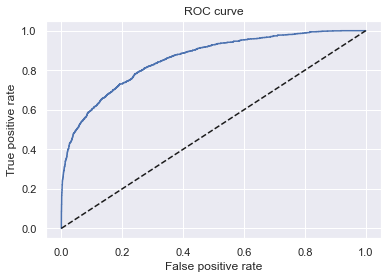

In [76]:
plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve')
# We name the graph "ROC curve".

# Accuracy

In [77]:
AUROC = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC)
# from a set of actual values and their predicted probabilities.
'{:.2f}'.format(AUROC)

'0.86'

## Gini and Kolmogorov-Smirnov

In [78]:
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')
# Sorts a dataframe by the values of a specific column.

In [79]:
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba,y_hat_test
2950,0,0.000042,0
4329,0,0.000093,0
3178,0,0.000098,0
5065,0,0.000110,0
1356,0,0.000122,0


In [80]:
df_actual_predicted_probs.tail()

,loan_data_targets_test,y_hat_test_proba,y_hat_test
43,1,0.997746,1
5180,1,0.997829,1
3547,1,0.997980,1
4686,1,0.998109,1
1023,1,0.998497,1


In [81]:
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()
# We reset the index of a dataframe and overwrite it.

In [82]:
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test
0,2950,0,0.000042,0
1,4329,0,0.000093,0
2,3178,0,0.000098,0
3,5065,0,0.000110,0
4,1356,0,0.000122,0


In [83]:
df_actual_predicted_probs['Cumulative N Population'] = df_actual_predicted_probs.index + 1
# We calculate the cumulative number of all observations.
# We use the new index for that. Since indexing in ython starts from 0, we add 1 to each index.
df_actual_predicted_probs['Cumulative N Good'] = df_actual_predicted_probs['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'good', which is the cumulative sum of the column with actual observations.
df_actual_predicted_probs['Cumulative N Bad'] = df_actual_predicted_probs['Cumulative N Population'] - df_actual_predicted_probs['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'bad', which is
# the difference between the cumulative number of all observations and cumulative number of 'good' for each row.

In [84]:
df_actual_predicted_probs['Cumulative Perc Population'] = df_actual_predicted_probs['Cumulative N Population'] / (df_actual_predicted_probs.shape[0])
# We calculate the cumulative percentage of all observations.
df_actual_predicted_probs['Cumulative Perc Good'] = df_actual_predicted_probs['Cumulative N Good'] / df_actual_predicted_probs['loan_data_targets_test'].sum()
# We calculate cumulative percentage of 'good'.
df_actual_predicted_probs['Cumulative Perc Bad'] = df_actual_predicted_probs['Cumulative N Bad'] / (df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['loan_data_targets_test'].sum())
# We calculate the cumulative percentage of 'bad'.

In [85]:
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad,Cumulative Perc Population,Cumulative Perc Good,Cumulative Perc Bad
0,2950,0,0.000042,0,1,0,1,0.000188,0.0,0.000246
1,4329,0,0.000093,0,2,0,2,0.000376,0.0,0.000492
2,3178,0,0.000098,0,3,0,3,0.000563,0.0,0.000739
3,5065,0,0.000110,0,4,0,4,0.000751,0.0,0.000985
4,1356,0,0.000122,0,5,0,5,0.000939,0.0,0.001231


Text(0.5, 1.0, 'Gini')

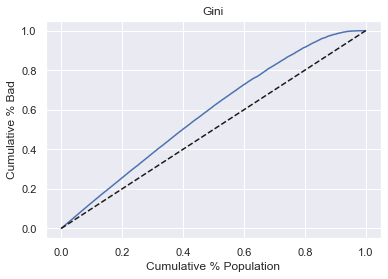

In [86]:
# Plot Gini
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Bad'])
# We plot the cumulative percentage of all along the x-axis and the cumulative percentage 'good' along the y-axis,
# thus plotting the Gini curve.
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Population'], linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('Cumulative % Population')
# We name the x-axis "Cumulative % Population".
plt.ylabel('Cumulative % Bad')
# We name the y-axis "Cumulative % Bad".
plt.title('Gini')
# We name the graph "Gini".

In [87]:
Gini = AUROC * 2 - 1
# Here we calculate Gini from AUROC.
Gini

0.7148669104727867

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

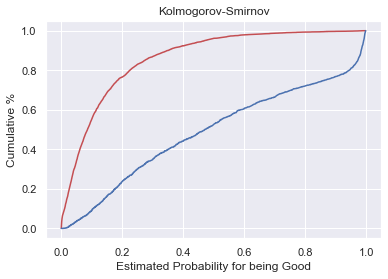

In [88]:
# Plot KS
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Bad'], color = 'r')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'bad' along the y-axis,
# colored in red.
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Good'], color = 'b')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'good' along the y-axis,
# colored in red.
plt.xlabel('Estimated Probability for being Good')
# We name the x-axis "Estimated Probability for being Good".
plt.ylabel('Cumulative %')
# We name the y-axis "Cumulative %".
plt.title('Kolmogorov-Smirnov')
# We name the graph "Kolmogorov-Smirnov".

In [89]:
KS = max(df_actual_predicted_probs['Cumulative Perc Bad'] - df_actual_predicted_probs['Cumulative Perc Good'])
# We calculate KS from the data. It is the maximum of the difference between the cumulative percentage of 'bad'
# and the cumulative percentage of 'good'.
KS

0.540265434459465

# Creating a Scorecard

In [90]:
summary_table

,Feature name,Coefficients
0,Intercept,-2.324182
1,loan_amnt,-1.364501
2,term,-0.369226
3,int_rate,2.113492
4,grade,1.969651
5,emp_length,0.021672
6,home_ownership,-0.006148
7,annual_inc,-0.045598
8,verification_status,-0.072087
9,pymnt_plan,0.000000


In [91]:
min_score = 300
max_score = 850

In [92]:
df_scorecard = summary_table

In [94]:
df_scorecard.groupby('Feature name')['Coefficients'].min()
# Groups the data by the values of the 'feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.

Feature name
Intercept                    -2.324182
Monthly_income               -0.045598
Monthly_supposed_payment      0.434500
Total_refund                  1.021337
acc_now_delinq               -0.034410
addr_state                    0.026627
annual_inc                   -0.045598
application_type             -0.161312
collection_recovery_fee      -1.570994
collections_12_mths_ex_med   -0.016538
delinq_2yrs                  -0.124189
dti                          -0.251844
emp_length                    0.021672
grade                         1.969651
home_ownership               -0.006148
initial_list_status           0.314134
inq_last_6mths                0.066403
int_rate                      2.113492
loan_amnt                    -1.364501
open_acc                     -0.237530
pub_rec                      -0.126515
purpose                      -0.029644
pymnt_plan                    0.000000
recoveries                   -6.845795
revol_bal                    -0.181208
revol_util  

In [95]:
min_sum_coef_1 = df_scorecard['Coefficients'].min()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the minimum values.
min_sum_coef = -1.5386183729406917

In [96]:
max_sum_coef_1 = df_scorecard['Coefficients'].max()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the minimum values.
max_sum_coef = 5.590270189646491

In [97]:
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# We multiply the value of the 'Coefficients' column by the ration of the differences between
# maximum score and minimum score and maximum sum of coefficients and minimum sum of cefficients.
df_scorecard

,Feature name,Coefficients,Score - Calculation
0,Intercept,-2.324182,-179.312669
1,loan_amnt,-1.364501,-105.272476
2,term,-0.369226,-28.486124
3,int_rate,2.113492,163.057747
4,grade,1.969651,151.960337
5,emp_length,0.021672,1.672008
6,home_ownership,-0.006148,-0.474329
7,annual_inc,-0.045598,-3.517960
8,verification_status,-0.072087,-5.561598
9,pymnt_plan,0.000000,0.000000


In [98]:
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# We divide the difference of the value of the 'Coefficients' column and the minimum sum of coefficients by
# the difference of the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we multiply that by the difference between the maximum score and the minimum score.
# Then, we add minimum score. 
df_scorecard

<ipython-input-98-6383eee17b30>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score


,Feature name,Coefficients,Score - Calculation
0,Intercept,-2.324182,239.393087
1,loan_amnt,-1.364501,-105.272476
2,term,-0.369226,-28.486124
3,int_rate,2.113492,163.057747
4,grade,1.969651,151.960337
5,emp_length,0.021672,1.672008
6,home_ownership,-0.006148,-0.474329
7,annual_inc,-0.045598,-3.517960
8,verification_status,-0.072087,-5.561598
9,pymnt_plan,0.000000,0.000000


In [99]:
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
# We round the values of the 'Score - Calculation' column.
df_scorecard

,Feature name,Coefficients,Score - Calculation,Score - Preliminary
0,Intercept,-2.324182,239.393087,239.0
1,loan_amnt,-1.364501,-105.272476,-105.0
2,term,-0.369226,-28.486124,-28.0
3,int_rate,2.113492,163.057747,163.0
4,grade,1.969651,151.960337,152.0
5,emp_length,0.021672,1.672008,2.0
6,home_ownership,-0.006148,-0.474329,-0.0
7,annual_inc,-0.045598,-3.517960,-4.0
8,verification_status,-0.072087,-5.561598,-6.0
9,pymnt_plan,0.000000,0.000000,0.0


In [153]:
df_scorecard['Score - Preliminary'] = abs(df_scorecard['Score - Preliminary'])
df_scorecard

,Feature name,Coefficients,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,Intercept,-2.324182,577.576461,578.0,0.004226,300.0
1,loan_amnt,-1.364501,-83.765124,84.0,0.475747,-750.0
2,term,-0.369226,-22.666359,23.0,0.074406,-203.0
3,int_rate,2.113492,129.744763,130.0,-0.420507,1162.0
4,grade,1.969651,120.914574,121.0,-0.308310,1083.0
5,emp_length,0.021672,1.330414,1.0,0.080444,12.0
6,home_ownership,-0.006148,-0.377422,0.0,0.381435,-3.0
7,annual_inc,-0.045598,-2.799234,3.0,0.079142,-25.0
8,verification_status,-0.072087,-4.425354,4.0,-0.351988,-40.0
9,pymnt_plan,0.000000,0.000000,0.0,0.000000,0.0


In [128]:
X_test_intercept = X_test.insert(0, 'Intercept', 1)
# We insert a column in the dataframe, with an index of 0, that is, in the beginning of the dataframe.
# The name of that column is 'Intercept', and its values are 1s.
X_test.head()

,Intercept,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,Monthly_supposed_payment,Total_refund,Monthly_income
17859,1,-1.038100,-0.657038,-0.587045,0.602702,0.093698,0.471572,-0.226811,-1.534839,0.0,0.208719,1.296509,-0.689548,-0.360911,-0.694837,0.478510,1.318030,-0.360703,0.079782,0.152431,0.972322,-0.400925,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,-2.842150,-0.891559,-1.137801,-0.989496,-1.011925,-0.226811
11524,1,0.147793,1.521983,0.026691,-0.161979,1.123245,-1.088284,-0.429747,0.651534,0.0,0.208719,-0.036645,-0.375480,-0.360911,-0.694837,-1.235486,-0.314012,0.060263,0.191961,-0.865001,-1.028466,-0.352073,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,0.181932,-0.710161,-0.279432,-0.285922,0.226584,-0.429747
21307,1,0.859330,-0.657038,-1.216812,1.367382,0.351085,-1.088284,1.746571,-1.534839,0.0,3.743495,-0.036645,-1.016854,-0.360911,-0.694837,0.478510,-0.314012,-0.585065,-0.159589,1.932937,0.972322,-0.186800,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,0.181932,-0.114842,0.132129,1.034947,0.456290,1.746571
13446,1,0.029204,1.521983,1.041189,-0.926659,-0.678462,-1.088284,-0.492727,0.651534,0.0,0.208719,1.296509,-0.065021,-0.360911,0.313793,-1.045042,-0.314012,-0.189739,-0.011129,-0.271499,-1.028466,0.436535,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,0.181932,-0.746460,-0.047194,-0.235868,0.287086,-0.492727
23324,1,0.029204,-0.657038,-1.425208,1.367382,0.608471,0.471572,-0.282793,-1.534839,0.0,0.208719,-0.036645,-0.829134,-0.360911,-0.694837,-0.092822,-0.314012,-0.385195,-0.101623,-0.525857,0.972322,-0.408821,-0.096581,-0.117306,-0.079717,0.012138,-0.025278,-0.07032,0.181932,-0.229294,0.123310,0.109689,-0.214748,-0.282793


In [130]:
X_test_intercept.shape

(5325, 34)

In [131]:
X_test.shape

(5325, 34)

In [132]:
scorecard_scores = df_scorecard['Score - Final']

In [133]:
scorecard_scores.shape

(34,)

In [134]:
scorecard_scores = scorecard_scores.values.reshape(34, 1)
scorecard_scores.shape

(34, 1)

In [135]:
y_scores = X_test_intercept.dot(scorecard_scores)
# Here we multiply the values of each row of the dataframe by the values of each column of the variable,
# which is an argument of the 'dot' method, and sum them. It's essentially the sum of the products.
y_scores.head()

,0
17859,2811.478188
11524,55.462238
21307,1358.410787
13446,567.023137
23324,920.046103


### From Credit Score to PD

In [136]:
sum_coef_from_score = ((y_scores - min_score) / (max_score - min_score))
# We divide the difference between the scores and the minimum score by
# the difference between the maximum score and the minimum score.
# Then, we multiply that by the difference between the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we add the minimum sum of coefficients.
sum_coef_from_score

,0
17859,4.566324
11524,-0.444614
21307,1.924383
13446,0.485497
23324,1.127357
11281,-0.525584
13083,2.723902
9844,1.278099
22005,0.575330
8779,0.979570


In [137]:
y_hat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)
# Here we divide an exponent raised to sum of coefficients from score by
# an exponent raised to sum of coefficients from score plus one.
y_hat_proba_from_score.head()

,0
17859,0.989711
11524,0.390642
21307,0.872626
13446,0.619045
23324,0.755351


In [138]:
y_hat_test_proba[0: 5]

array([0.96377546, 0.00556015, 0.35822168, 0.18360882, 0.18778105],
      dtype=float32)